In [1]:
%matplotlib inline

"""
Questions
    Write python code to simulate this.
    
    What are the error bars as a function of N? Express this using big-O 
    notation.
    
    Plot a graph showing how your estimate of π changed as the number of 
    samples increased (for a single simulation). Include the true value 
    and show your theoretical error bars as well.
    
    Suggest modifications we can make to:
        keep the code simple.
        keep the estimate as accurate as possible for a given number of 
        samples.
    
    Mathematicians have a fascination with calculating as many digits of 
    π as they can. If one were to leave theoretical justifications aside,
    how many digits of π would one need in a practical situation. Think 
    of a practical situation where an accurate estimate of π is needed. 
    Use Fermi estimation to try and determine how digits you need, before
    uncertainty from other sources will dominate. How long would you need
    to run your code to achieve such accuracy?
    
"""

import numpy as np
import matplotlib.pyplot as plt

N = 1000
radius = 5
width = 15
height= 10
num_of_throws = range(1,N+1)

class Dartboard(object):
    def __init__(self, radius, x, y):
        self.radius = radius
        self.x, self.y = x, y

    def is_in(self, xi, yi):
        if np.sqrt((xi-self.x)**2 + (yi-self.y)**2) < self.radius:
            return True
        else:
            return False
        
class DartGame(object):
    def __init__(self, radius, width, height):
        self.radius, self.width, self.height = radius, width, height
        self.area = width*height
        self.dartboard = Dartboard(radius, self.width/2., self.height/2.)
        self.hits = 0
        self.misses = 0

    def throw(self):
        x = np.random.random()*width
        y = np.random.random()*height
        if self.dartboard.is_in(x,y):
            self.hits +=1
        else:
            self.misses +=1


# What are the error bars as a function of N? Express this using big-O notation.


Probability of a hitting the circular board when throwing a dart is given by

$$ p = \frac{\pi r^2}{A}$$
where $A$ is the total rectangular area and $r$ is the radius of the dartboard.

Using the formula for binomial standard deviation, we can calculate the standard deviation for number of hits given n throws:

$$ \sigma_h = \sqrt{n p(1-p)} = \sqrt{n \cdot \frac{\pi r^2}{A} \cdot \frac{A -\pi r^2}{A}} = \frac{r}{A} \sqrt{n \pi (A-\pi r^2)} $$

However, we actually want to know $\sigma_\pi$, the standard deviation of the estimated $\pi$. Number of hits and estimated $\pi$ are related by the following equation:

$$ \hat{\pi} = \frac{n_{hit} A}{nr^2}$$

We can set constant $C_1$ to be $\frac{A}{nr^2}$, then we have
$$ \hat{\pi} = C_1 n_{hit}$$

Using the formula for standard deviation, we have
$$\sigma_\pi = \sqrt{E[(\hat{\pi}-\bar{\hat{\pi}})^2]} = \sqrt{E[(C_1 n_{hit}-\bar{C_1 n_{hit}})^2]} = \sqrt{E[C_1^2 (n_{hit}-\bar{n_{hit}})^2]} = C_1 \sqrt{E[(n_{hit}-\bar{n_{hit}})^2]}$$

We see that the expression $\sqrt{E[(n_{hit}-\bar{n_{hit}})^2]}$ is exactly $\sigma_h$, the standard deviation of number of hits. Therefore

$$\sigma_\pi = C_1 \sigma_h = \frac{A}{nr^2} \cdot \frac{r}{A} \sqrt{n \pi (A-\pi r^2)} = n^{- \frac{1}{2}} \cdot \frac{\sqrt{\pi (A-\pi r^2)}}{r}$$

Let $C_2$ be $\frac{\sqrt{\pi (A-\pi r^2)}}{r}$, we have
$$ \sigma_\pi = C_2 n^{- \frac{1}{2}} = O(n^{- \frac{1}{2}})$$


-----------

Below is a plot showing the theoretical standard error of $\pi$ estimates as $n$ scales.

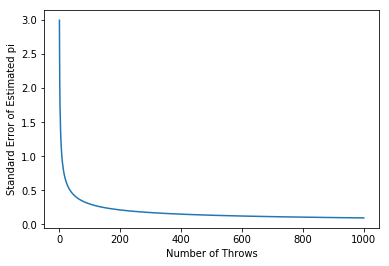

In [2]:
area = width*height
prob = np.pi*(radius**2)/(width*height)
theo_err =[]
for i in num_of_throws:
    # First calculate standard error of num of hits
    se_n_hits = np.sqrt(i * prob  * (1-prob)) 
    # Standard error of estimated pi is porportional to that
    se_este_pi = se_n_hits * area/(i*radius**2)
    theo_err.append(se_este_pi)
    
plt.plot(num_of_throws, theo_err)
plt.xlabel("Number of Throws")
plt.ylabel("Standard Error of Estimated pi")
plt.show()

# Plot a graph showing how your estimate of π changed as the number of samples increased (for a single simulation). Include the true value and show your theoretical error bars as well.

In [3]:
#%%timeit
# Version 1
# Run simulation
dart_sim = DartGame(radius, width, height)
pi_estimates = []

for throws_so_far in num_of_throws:
    dart_sim.throw()
    est_circ_area = dart_sim.area / float(throws_so_far) * dart_sim.hits
    est_pi = est_circ_area/float(radius**2)
    pi_estimates.append(est_pi)

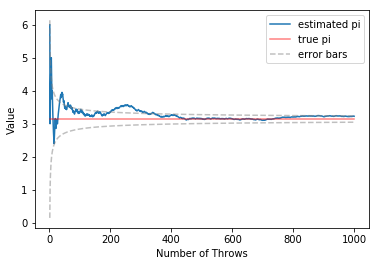

In [4]:
# Plot
true_pi = np.array([np.pi]*N)
theo_err = np.array(theo_err)
upper_bars = true_pi + theo_err
lower_bars = true_pi - theo_err

plt.plot(num_of_throws, pi_estimates, label="estimated pi")
plt.plot(num_of_throws, true_pi, "red", alpha=0.5, label="true pi")
plt.plot(num_of_throws, upper_bars, "grey", ls="--", alpha=0.5, 
         label="error bars")
plt.plot(num_of_throws, lower_bars, "grey", ls="--", alpha=0.5)
plt.xlabel("Number of Throws")
plt.ylabel("Value")
plt.legend()
plt.show()

# Suggest modifications we can make to:

## Keep the code simple

To make the code simple (I assume this means short and fast), we could use matrix operation on numpy arrays, rather than for-loops + python list + object-oriented design. This would however sacrifice the readability and connection with human intuition.

The code below is the more efficient implementation (let's call it Version 2, and the previous implementation Version 1):

In [5]:
#%%timeit
# Version 2

# Coordinates of center of dartboard
xc = width/2.
yc = height/2.
rect_area = width*height

# Array indicating coordinates from each throw.
X = np.random.random(N)*width
Y = np.random.random(N)*height

# Using in-place operations for memory efficiency
X -= xc; X **= 2    
Y -= yc; Y **= 2    
X += Y ; X **= 0.5  # result is equivalent to sqrt((X-xc)^2 + (Y-yc)^2)

# Indicator array associated with event of hitting the dartboard
I = (X<radius).astype(int) # 1 if hit; 0 if miss

N_hits = np.cumsum(I) # array for number of hits
N_throws = np.arange(1, N+1).astype(float) # array for number of throws
E_area = rect_area / N_throws * N_hits # estimated area of circle
r_square = radius**2
E_pi = E_area/r_square # estimated pi


Using %%timeit magic command to measure cell run time, we see that for N=1000, the second version is about two orders of magnitude faster than the first version.

    Version 1: 100 loops, best of 3: 4.85 ms per loop
    
    Version 2: 1000 loops, best of 3: 486 µs per loop


For curiosity, I also tested when N=100000:

    Version 1: 1 loop, best of 3: 457 ms per loop
    
    Version 2: 100 loops, best of 3: 4.6 ms per loop
    

The second test is actually not necessary because we know that implementation only affects the constant in time complexity, therefore would not change the scaling behavior. But anyhow, it verifies the theoretical complexity $O(N)$ of the simulation algorithm.


## Keep the estimate as accurate as possible for a given number of samples 


To keep estimate as accurate as possible for a given number of samples, I would suggest bootstrapping subsamples from the sample and using that to generate many estimates of pi, and then take the average.

# How many digits of π would one need in a practical situation


Let's say I want to synthesize a piece of jewelry that is a perfect sphere (radius=1cm) made of diamond. I want to know what its volume would be and it has to be precise to the atomic level. 

Distance between carbon atoms in diamond is 0.142 nm (Warren-Gregory, 2001). So we only need a calculation that's precise to roughly $(0.1nm)^3$ = $10^{-10} cm^3$.

Since sphere volume is $V = 4/3 \pi r^3 = 4/3 \pi \cdot 1 cm^3$, we can estimate that we need 10 digits of $\pi$.

We already calculated that $\sigma = O(n^{\frac{1}{2}})$, therefore for error bar to be smaller than $10^{-10}$, n has to be more than $10^{20}$.

Performance results above showed that it takes 4.6ms for Version 2 to run when $n=10^5$, therefore it will take $10^{15} \cdot 4.6$ ms = $145865$ years to run when $n=10^{20}$.

---------
References

Warren-Gregory, A. (2001). Distance Between Carbon Atoms. *The Physics Factbook*. Retrieved from https://hypertextbook.com/facts/2001/AliceWarrenGregory.shtml.